<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2019 Reduction Exercise: Part 4</h2>

In this part you will take your aligned images and combine them using the same tools that we used to combine our flats.

We took short exposures of every target to deal with saturation.  Note, however, that we can't just combine the short and long exposures and expect the saturation to go away.  In principle we would need to produced combinations of the short and long exposures separately and use photometry from faint stars from our long exposures and from the saturated stars from our bright exposures.  For the sake of expediency we are going to instead just use the long exposures and ignore the brightest stars.


In [51]:
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc
from matplotlib import pyplot as plt
from ccdproc import Combiner
from astropy.io import ascii
from astropy.io import fits
import os, glob, time

In [52]:
#this specifies the reduction directory
#****
#put your own path
redpath = "/home/a533d712/ASTR596/Data/Reduced/"

First we write a routine to read in images.

In [53]:
def readimage(filename):
    imgfile = os.path.join('{}'.format(redpath), filename)
    print('Reading {}'.format(imgfile))
    img, hdr = fits.getdata(imgfile, header=True)
    return img,imgfile,hdr

This routine will display an image

In [54]:
def display_image(img, minclip=5, maxclip=95, label=None, cmap='Greys_r', 
                  srcs=None, projection=None, calibrated=False):
    """Simple wrapper to display an image.
    
    """
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ZScaleInterval as Interval
    from astropy.visualization.mpl_normalize import ImageNormalize

    #from astropy.visualization import simple_norm
    #norm = simple_norm(img, min_percent=minclip, max_percent=maxclip)

    interval = Interval(contrast=0.5)
    vmin, vmax = interval.get_limits(img)
    norm = ImageNormalize(interval=interval, stretch=Stretch(a=0.9))

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': projection})
    im = ax.imshow(img, origin='lower', norm=norm, cmap=cmap,
                   vmin=vmin, vmax=vmax)
    if projection:
        ax.coords.grid(color='red')
        ax.coords['ra'].set_axislabel('Right Ascension')
        ax.coords['dec'].set_axislabel('Declination')      
    else:
        ax.set_xlabel('Column Number (pixels)')
        ax.set_ylabel('Row Number (pixels)')

    # Mark the locations of stars.
    if srcs:
        from photutils import CircularAperture
        pos = np.transpose((srcs['xcentroid'], srcs['ycentroid']))
        aps = CircularAperture(pos, r=12.)
        aps.plot(color='red', lw=1.5, alpha=0.6, axes=ax)
      
    # Make room for the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.28, 0.05, 0.45])
    c = plt.colorbar(im, cax=cax)
    if label:
        c.set_label(label)
    else:
        if calibrated:
            c.set_label(r'Intensity ($e^{-}/s$)')
        else:
            c.set_label('Intensity (ADU)')

This function will do the combination.  

In [55]:
def im_combine(comblist,outfile):
    #filelist is the name of a text file that contains a list of all the files to combine
    comblistpath = redpath + comblist
    
    #initialize a list of files to combine
    comb_imlist = []

    #this way of opening the file ensures that it closes after the loop is done.
    with open(comblistpath,'r') as fp:
        
        #read first line
        iline = 0
        line = fp.readline()

        #build the combine list of all images
        #read every subsequent line
        while line:
            #this removes the trailing newline charactter and converts the output list to a scalar
            imname = line.split()
            imname = imname[0]
            
            #create the image name, including the path
            imstr = redpath + imname
            #read that into a CCDData object.  This allows you to specify a unit
            im = CCDData.read(imstr)

            #read in the image headers
            imtest, hdr = fits.getdata(imstr, header=True) 
            
            #normalize each image by its exposure time.  This allows you to combine images of 
            #different exposure times.
            im = im.divide(hdr['EXP_TIME'] * u.electron)
            
            #make a list of all the CCDData instances of each image
            comb_imlist = comb_imlist + [im]
        
        
            line = fp.readline()
            iline = iline + 1

    #Combiner list of all bias images
    im_combiner = Combiner(comb_imlist)


    #generate a median combined image
    combined_img = im_combiner.median_combine()

    #now write out this file
    combined_imgpath = redpath + outfile

    #Change the exposure time keyword to reflect that these images have been normalized to 1 second
    hdr['EXP_TIME'] = 1.0
    #this takes the header of the last file in the list writes it as the header of the combined file.
    combined_img.meta = hdr
    combined_img.write(combined_imgpath, overwrite=True)


In [56]:
#*********
#Here you will need to provide names of lists of your images, and the name of an output file 
#for each combined image
comb_imname_ngc7296_V = 'ngc7276_V_comb.fits'
im_combine('ngc7296_V_comblist',comb_imname_ngc7296_V)

comb_imname_ngc7296_B = 'ngc7276_B_comb.fits'
im_combine('ngc7296_B_comblist',comb_imname_ngc7296_B)

<h3> Determine the Astrometry of your image </h3>
   
"Astrometry" is the process of determining where your data are pointing, i.e.,figuring out the transformation matrix between pixel coordinates (x,y) and celestial coordinates (RA,Dec), which has a long, rich history. In a nutshell, this transformation matrix is determined by comparing the observed positions of stars (or other reference sources) against their known positions (i.e., using an external, calibrated catalog).

Needless to say there are many intricacies involved in astrometry, which I encourage you to delve into.  But for now we can proceed with just the basics and use the [astrometry.net](http://astrometry.net) engine to determine the astrometric solution of our data.

In [57]:
#******
#This reads in images into variables that we will use.  You will need to do this for
#every image that you combined
img_ngc7296_V, imgfile_ngc7296_V, hdr_ngc7296_V = readimage("ngc7276_V_comb.fits")
img_ngc7296_B, imgfile_ngc7296_B, hdr_ngc7296_B = readimage("ngc7276_B_comb.fits")



Reading /home/a533d712/ASTR596/Data/Reduced/ngc7276_V_comb.fits
Reading /home/a533d712/ASTR596/Data/Reduced/ngc7276_B_comb.fits


First, we need the observed positions of the stars in this image, but in order to detect those stars we first have to model and subtract the sky background from the data.  This is because we want to detect stars at a certain level above the background and if the background varies across the image this becomes hard.  So we need to create an image with the mean background counts removed.

We'll build the sky background by measuring the median pixel value in a "low-resolution" mesh grid, which we will then interpolate onto the original resolution of the image. For additional details see the photutils tutorial on Background Estimation.

In [58]:
def get_sky_background(img, verbose=True):
    from astropy.stats import SigmaClip
    from photutils import Background2D, MedianBackground
    sigma_clip = SigmaClip(sigma=4.)
    bkg = Background2D(img, (100, 100), filter_size=(10, 10), sigma_clip=sigma_clip, 
                       bkg_estimator=MedianBackground())
    if verbose:
        print('Sky background median = {:.3f}, rms = {:.3f} electrons.'.format(bkg.background_median, bkg.background_rms_median))
    return bkg

You will need to repeat these commands for each combined image and band combination

In [59]:
#***********
bkg_V = get_sky_background(img_ngc7296_V, verbose=True)

bkg_B = get_sky_background(img_ngc7296_B, verbose=True)

Sky background median = 2.191, rms = 0.061 electrons.
Sky background median = 1.912, rms = 0.053 electrons.


In [60]:
#***********
img_ngc7296_V_nosky = img_ngc7296_V - bkg_V.background
img_ngc7296_B_nosky = img_ngc7296_B - bkg_B.background

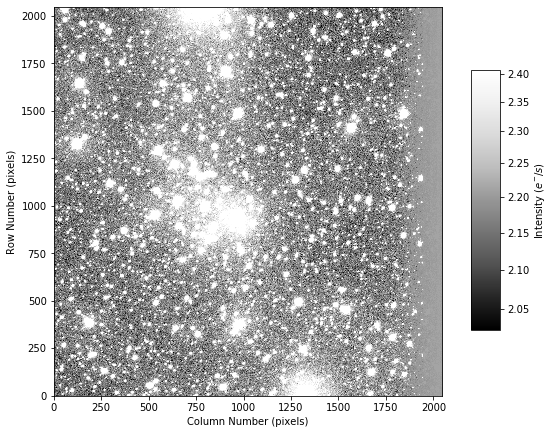

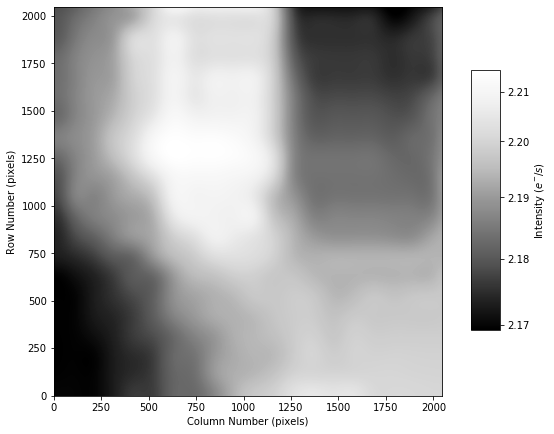

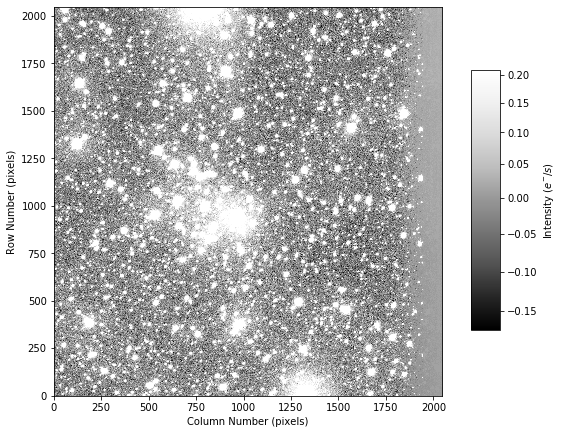

In [61]:
#***********
display_image(img_ngc7296_V, calibrated=True)
display_image(bkg_V.background, calibrated=True)
display_image(img_ngc7296_V_nosky,calibrated=True)
#now write out this file
bkgsub_imname = "ngc7276_V_comb.fits".replace('.fits','bkgsub.fits',1)
bkg_sub_imgpath = redpath + bkgsub_imname

#include in the header that we have performed a background subtraction
hdr_ngc7296_V['BACKGROUND'] = 'Background was Subtracted'

#write the background subtracted image with the header information
fits.writeto(bkg_sub_imgpath, img_ngc7296_V_nosky, hdr_ngc7296_V, overwrite=True)



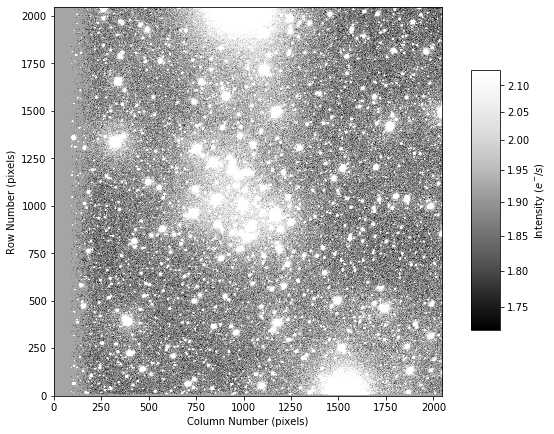

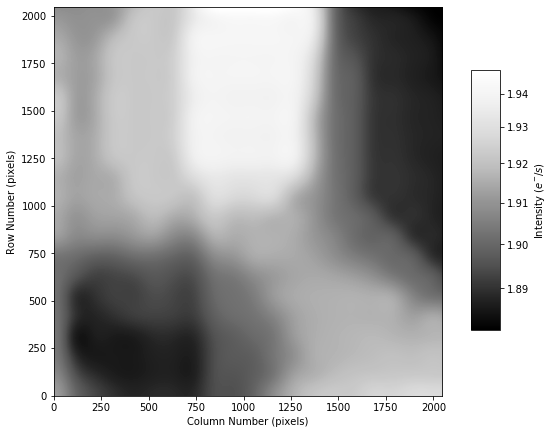

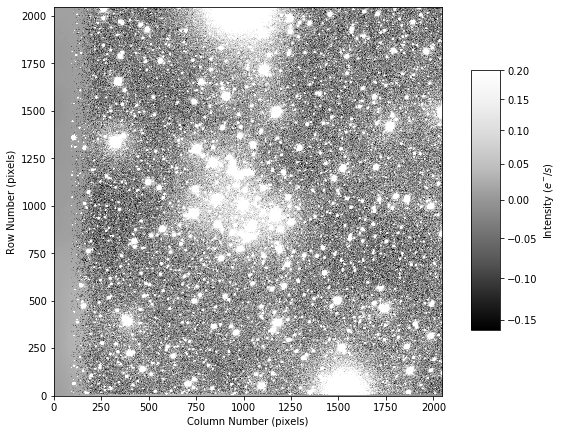

In [62]:
#***********
display_image(img_ngc7296_B, calibrated=True)
display_image(bkg_B.background, calibrated=True)
display_image(img_ngc7296_B_nosky,calibrated=True)
#now write out this file
bkgsub_imname = "ngc7276_B_comb.fits".replace('.fits','bkgsub.fits',1)
bkg_sub_imgpath = redpath + bkgsub_imname

#include in the header that we have performed a background subtraction
hdr_ngc7296_B['BACKGROUND'] = 'Background was Subtracted'

#write the background subtracted image with the header information
fits.writeto(bkg_sub_imgpath, img_ngc7296_B_nosky, hdr_ngc7296_B, overwrite=True)


This routine makes histogrames of the original and background subtracted images.

In [63]:
def qa_background(img,img_nosky,bkg):
    med, sig = bkg.background_median, bkg.background_rms_median
    vrange = (-3*sig, med+5*sig)
    fig, ax = plt.subplots(figsize=(7, 5))
    _ = ax.hist(img.flatten(), bins=100, range=vrange, label='Image w/ Background')
    #_ = ax.hist(bkg.background.flatten(), bins=50, range=(-sig, med+5*sig), label='Background')
    _ = ax.hist(img_nosky.flatten(), bins=100, range=vrange, label='Image w/o Background')
    ax.axvline(x=bkg.background_median, lw=2, ls='-', color='k')
    ax.set_xlabel('Intensity (e-/s)')
    ax.set_ylabel('Number')
    ax.legend(fontsize=12, frameon=False)

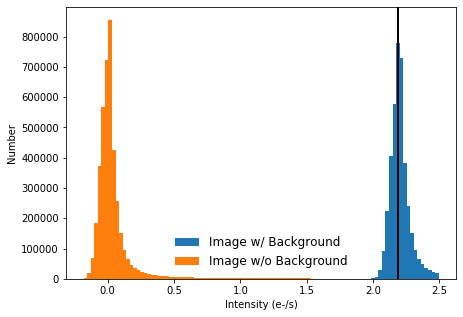

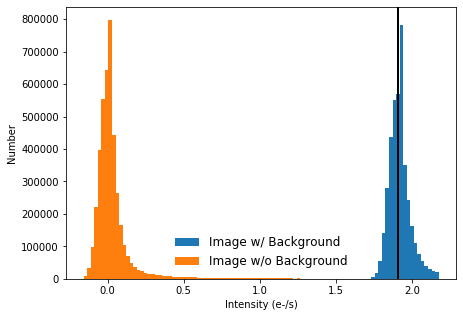

In [64]:
#***********
qa_background(img_ngc7296_V, img_ngc7296_V_nosky,bkg_V)
qa_background(img_ngc7296_B, img_ngc7296_B_nosky,bkg_B)

In [65]:
def find_stars(image, imgfile, fwhm=3.0, nsigma=3, sigma=None, 
               verbose=True, overwrite=False):
    from astropy.table import Table
    
    starsfile = os.path.join(redpath, 'stars-{}'.format(os.path.basename(imgfile)))
    if not os.path.isfile(starsfile) or overwrite:
        from photutils import DAOStarFinder
        if sigma is None:
            sigma = np.std(image)

        daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
        srcs = daofind(image)
        # reverse-sort by flux 
        srcs.sort('flux')
        srcs.reverse()
        if verbose:
            print('Found {} sources'.format(len(srcs)))

        print('Writing {} stars to {}'.format(len(srcs), starsfile))
        srcs.write(starsfile, overwrite=True)
    else:
        srcs = Table.read(starsfile)
        print('Read {} stars from {}'.format(len(srcs), starsfile))
    return srcs

In [76]:
#***********
srcs_V = find_stars(img_ngc7296_V_nosky, imgfile_ngc7296_V, sigma=bkg_V.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=True)
srcs_V

srcs_B = find_stars(img_ngc7296_B_nosky, imgfile_ngc7296_B, sigma=bkg_B.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=True)
srcs_B

Found 2297 sources
Writing 2297 stars to /home/a533d712/ASTR596/Data/Reduced/stars-ngc7276_V_comb.fits
Found 2085 sources
Writing 2085 stars to /home/a533d712/ASTR596/Data/Reduced/stars-ngc7276_B_comb.fits


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
7,1527.1616709347225,9.792856002311307,0.3280624283263068,0.22203076072394506,0.6485828566868513,25,0.0,1172.5372895018347,3450.4727718058407,-8.844696511682871
1536,2039.9925081209456,1493.106143127355,0.4374274441975736,-0.21032643552988473,-0.18560915091828878,25,0.0,1122.814422586241,2543.120104681557,-8.513417178033379
1534,1168.3122741998343,1493.0111758363612,0.44331426269083835,-0.10345237822184426,-0.24304134255023424,25,0.0,1099.387393261738,2318.2169037034046,-8.412885170607387
1745,1103.5355829797188,1714.162241467974,0.46379925917460446,-0.060842680363612685,-0.30240277875209587,25,0.0,994.9797440533973,2102.466643339143,-8.306822785575989
1034,993.5066304503208,1003.735841453208,0.4507864650893666,-0.11997438453679643,-0.19445832489530268,25,0.0,981.2896817728795,1924.7572912022115,-8.210939933653972
1459,1764.0970557404514,1416.4145806957874,0.436787855773277,-0.11373004487569191,-0.16967518850965072,25,0.0,858.2949519011187,1894.728995453463,-8.193867753180031
970,1162.7873336362236,947.4295140236934,0.33822529778509114,-0.00647538495724586,-0.23354586149060264,25,0.0,1146.7165140284853,1812.960995909854,-8.145971151933013
1382,322.960265389903,1334.8277042148259,0.37431917098463297,0.07891074935696119,-0.08339925643286006,25,0.0,1153.01615308498,1796.5648567624423,-8.136107250102182
1069,850.0998700855363,1032.6591862922019,0.42555343362402753,-0.0384236594739865,-0.17740777898087823,25,0.0,832.4316925761391,1686.1316070014939,-8.067228673592323


Visualize the image again with the detected sources overlaid.

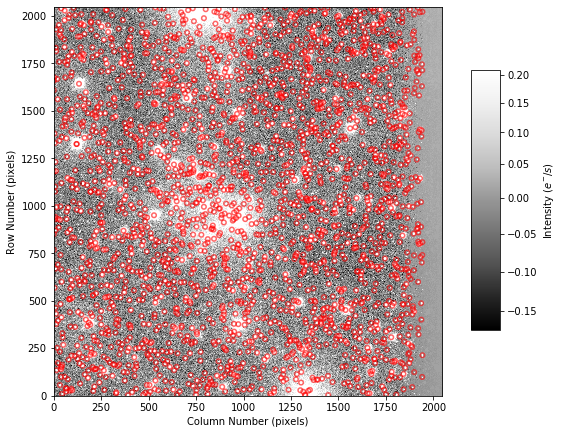

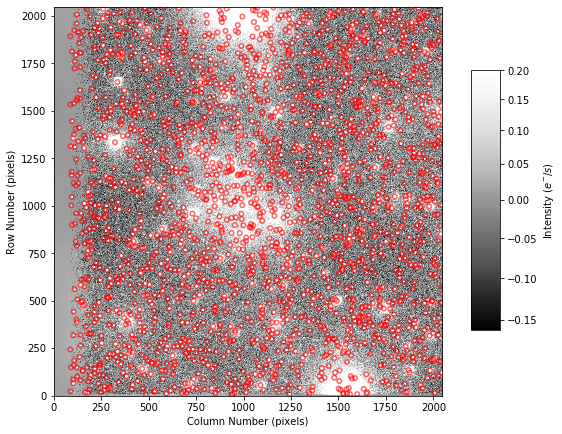

In [67]:
#***********
display_image(img_ngc7296_V_nosky, srcs=srcs_V, calibrated=True)
display_image(img_ngc7296_B_nosky, srcs=srcs_B, calibrated=True)

Now we're ready to find the astrometric solution by uploading our table of sources (actually, their x,y positions) to astrometry.net, which returns a FITS header with the transformation matrix we need / want. For this next step you'll need your astrometry.net API key, which you can find (if you're logged in) at this site http://nova.astrometry.net/api_help.

Please do not use my API key!

In [77]:
from astroquery.astrometry_net import AstrometryNet
AstrometryNet.key = 'rlwszmpyglhfwcuh' #Replaced to anna's key

def get_astrometry(imgfile, srcs=None, api_key=None, prefix='w', overwrite=False):
    from astropy.io import fits
    import astropy.units as u
    from astropy.coordinates import SkyCoord


    wcsfile = os.path.join(redpath, '{}{}'.format(prefix, os.path.basename(imgfile)))
    if not os.path.isfile(wcsfile) or overwrite:
        img, hdr = fits.getdata(imgfile, header=True)

        # Initialize the API.
        ast = AstrometryNet()
        if api_key:
            ast.api_key = api_key
        #ast.show_allowed_settings()

        # Get the initial position center based on the header.
        c = SkyCoord(hdr['RA']+hdr['DEC'], unit=(u.hourangle, u.deg))
        print('Initial RA, Dec = {:.5f}, {:.5f}'.format(c.ra.value, c.dec.value))

        # Query the astrometry.net engine!
        t0 = time.time()
        wcshdr = ast.solve_from_source_list(
            srcs['xcentroid'], srcs['ycentroid'], hdr['naxis1'], hdr['naxis2'],
            center_ra=c.ra.value, center_dec=c.dec.value, radius=15/60.0, 
            scale_type='ev', scale_est=0.4, scale_err=10, scale_units='arcsecperpix',
            crpix_center=True,solve_timeout=180)
        #wcshdr = ast.solve_from_image(imgfile)
        #print('Total time = {:.3f} min'.format((time.time() - t0)/60))

        # update the original header
        for key in wcshdr.keys():
            if key not in hdr and key != 'COMMENT' and key != 'HISTORY':
                hdr[key] = wcshdr[key]

        print('Writing {}'.format(wcsfile))
        fits.writeto(wcsfile, img, header=wcshdr, overwrite=True)        
    else:
        wcshdr = fits.getheader(wcsfile)

    return wcsfile, wcshdr

This does the astrometric calibration, which means it writes a new version of your image starting with 'w' that now contains a header that allows software, e.g. DS9 to translate between pixel and sky coordinates.

To use this you will need to get an account an astrometry.net and get your own API key.  **Do not use mine**

Running this on a single image can take time

In [79]:
#***********
my_api = 'rlwszmpyglhfwcuh' #Replaced to anna's key
%time wcsfile, wcshdr = get_astrometry(imgfile_ngc7296_V, srcs_V, api_key=my_api, overwrite=True)
wcshdr


Initial RA, Dec = 337.00833, 52.31667
Solving..........................................................Writing /home/a533d712/ASTR596/Data/Reduced/wngc7276_V_comb.fits
CPU times: user 404 ms, sys: 35 ms, total: 439 ms
Wall time: 1min 2s


SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =         336.96545454 / RA  of reference point                         
CRVAL2  =        52.3094700364 / DEC of reference point                         
CRPIX1  =               1024

In [80]:
my_api = 'rlwszmpyglhfwcuh' #Replaced to anna's key
%time wcsfile, wcshdr = get_astrometry(imgfile_ngc7296_B, srcs_B, api_key=my_api, overwrite=True)
wcshdr

Initial RA, Dec = 337.00833, 52.31667
Solving...............................................................................Writing /home/a533d712/ASTR596/Data/Reduced/wngc7276_B_comb.fits
CPU times: user 518 ms, sys: 59.8 ms, total: 577 ms
Wall time: 1min 25s


SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        336.998424054 / RA  of reference point                         
CRVAL2  =        52.3103005464 / DEC of reference point                         
CRPIX1  =               1024

Now repeat the necessary function calls to astrometrically calibrate all your images